In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-m2i9uwbc
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-m2i9uwbc
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
from __future__ import print_function, division
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import Activation
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation,ZeroPadding2D, LeakyReLU

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper Function

In [ ]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)

    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]

    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)

    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')

    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')

    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

## Generator

In [ ]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    # Input Layer
    in_img = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='generator')

## Discriminator

In [ ]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='discriminator')

## GAN

In [ ]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

## Train GAN model

In [ ]:
# Define empty lists to store loss values
generator_losses = []
discriminator_losses = []

In [ ]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    blue_photo = data[0]
    blue_sketch = data[1]

    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')

        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):
            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))

            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            d_loss = 0.5 * np.add(d_loss1, d_loss2)

            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            # Append the loss values to the respective lists
            generator_losses.append(g_loss)
            discriminator_losses.append(d_loss)

            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))

        # summarize model performance
        summarize_performance(i, g_model, d_model, dataset, target_dir)

        if i+1 == n_epochs:
            break


## Loss Function

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)

    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)

    return (0.2 * px_loss) + (0.8 * ctx_loss)

## Load Dataset

In [ ]:
# dataset path
b_photo_path = '/content/drive/MyDrive/Project/Dataset/CUHK/Training photo/'
b_sketch_path = '/content/drive/MyDrive/Project/Dataset/CUHK/Training sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

In [ ]:
#plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[15]).astype('uint8'), cv2.COLOR_BGR2RGB))

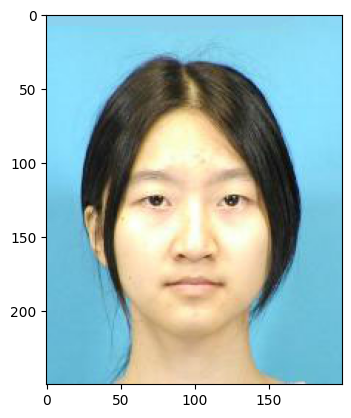

In [ ]:
image_path = blue_photo[15]

# Check if the image path is valid
if not os.path.exists(image_path):
    print("Invalid image path:", image_path)
else:
    # Read the image
    image = cv2.imread(image_path)

    # Check if the image was successfully read
    if image is None:
        print("Failed to read image:", image_path)
    else:
        # Convert to RGB color space and display the image
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.show()


In [ ]:
#plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))

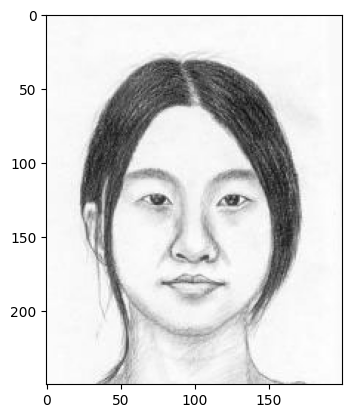

In [ ]:
sketch_path = blue_sketch[15]

# Check if the image path is valid
if not os.path.exists(image_path):
    print("Invalid image path:", image_path)
else:
    # Read the image
    image = cv2.imread(sketch_path)

    # Check if the image was successfully read
    if image is None:
        print("Failed to read image:", image_path)
    else:
        # Convert to RGB color space and display the image
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.show()


## Define GAN Model

In [ ]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [ ]:
gan_model.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 generator (Functional)         (None, 256, 256, 3)  41825691    ['input_8[0][0]']                
                                                                                                  
 discriminator (Functional)     (None, 64, 64, 1)    539203      ['input_8[0][0]',                
                                                                  'generator[0][0]']              
                                                                                                

In [ ]:
opt = Adam(lr=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

## Start Training

In [ ]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], '/content/drive/MyDrive/Project/Models/Pixel[50]_Context[08]/', n_epochs = 50, n_batch=16)

 ========== Epoch 1 ========== 
1/1 [==============================] - 0s 92ms/step
Batch : 1, D Loss : 3.608 | G Loss : 16.772
1/1 [==============================] - 0s 84ms/step
Batch : 2, D Loss : 3.500 | G Loss : 16.990
1/1 [==============================] - 0s 59ms/step
Batch : 3, D Loss : 3.613 | G Loss : 16.720
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.565 | G Loss : 16.687
1/1 [==============================] - 0s 29ms/step
Batch : 5, D Loss : 3.618 | G Loss : 17.221
1/1 [==============================] - 0s 22ms/step


>Saved: plot_000001.png and g_model & d_model
 ========== Epoch 2 ========== 
1/1 [==============================] - 0s 48ms/step
Batch : 1, D Loss : 3.607 | G Loss : 16.952
1/1 [==============================] - 0s 31ms/step
Batch : 2, D Loss : 3.526 | G Loss : 16.895
1/1 [==============================] - 0s 47ms/step
Batch : 3, D Loss : 3.518 | G Loss : 17.152
1/1 [==============================] - 0s 37ms/step
Batch : 4, D Loss : 3.572 | G Loss : 16.709
1/1 [==============================] - 0s 37ms/step
Batch : 5, D Loss : 3.549 | G Loss : 16.849
1/1 [==============================] - 0s 22ms/step


>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
1/1 [==============================] - 0s 54ms/step
Batch : 1, D Loss : 3.563 | G Loss : 18.225
1/1 [==============================] - 0s 47ms/step
Batch : 2, D Loss : 3.615 | G Loss : 17.722
1/1 [==============================] - 0s 44ms/step
Batch : 3, D Loss : 3.547 | G Loss : 16.657
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.585 | G Loss : 17.100
1/1 [==============================] - 0s 34ms/step
Batch : 5, D Loss : 3.646 | G Loss : 16.724
1/1 [==============================] - 0s 46ms/step


>Saved: plot_000003.png and g_model & d_model
 ========== Epoch 4 ========== 
1/1 [==============================] - 0s 33ms/step
Batch : 1, D Loss : 3.588 | G Loss : 16.549
1/1 [==============================] - 0s 31ms/step
Batch : 2, D Loss : 3.558 | G Loss : 17.646
1/1 [==============================] - 0s 34ms/step
Batch : 3, D Loss : 3.604 | G Loss : 17.049
1/1 [==============================] - 0s 48ms/step
Batch : 4, D Loss : 3.594 | G Loss : 16.908
1/1 [==============================] - 0s 50ms/step
Batch : 5, D Loss : 3.529 | G Loss : 17.235
1/1 [==============================] - 0s 21ms/step


>Saved: plot_000004.png and g_model & d_model
 ========== Epoch 5 ========== 
1/1 [==============================] - 0s 32ms/step
Batch : 1, D Loss : 3.603 | G Loss : 16.891
1/1 [==============================] - 0s 33ms/step
Batch : 2, D Loss : 3.579 | G Loss : 16.783
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.623 | G Loss : 17.368
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.503 | G Loss : 16.939
1/1 [==============================] - 0s 52ms/step
Batch : 5, D Loss : 3.619 | G Loss : 17.494
1/1 [==============================] - 0s 30ms/step


>Saved: plot_000005.png and g_model & d_model
 ========== Epoch 6 ========== 
1/1 [==============================] - 0s 30ms/step
Batch : 1, D Loss : 3.601 | G Loss : 17.115
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.562 | G Loss : 17.580
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.590 | G Loss : 16.689
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.576 | G Loss : 17.157
1/1 [==============================] - 0s 29ms/step
Batch : 5, D Loss : 3.627 | G Loss : 17.016
1/1 [==============================] - 0s 34ms/step


>Saved: plot_000006.png and g_model & d_model
 ========== Epoch 7 ========== 
1/1 [==============================] - 0s 33ms/step
Batch : 1, D Loss : 3.540 | G Loss : 16.828
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.629 | G Loss : 16.821
1/1 [==============================] - 0s 29ms/step
Batch : 3, D Loss : 3.610 | G Loss : 17.406
1/1 [==============================] - 0s 29ms/step
Batch : 4, D Loss : 3.582 | G Loss : 17.301
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.617 | G Loss : 16.915
1/1 [==============================] - 0s 21ms/step


>Saved: plot_000007.png and g_model & d_model
 ========== Epoch 8 ========== 
1/1 [==============================] - 0s 32ms/step
Batch : 1, D Loss : 3.638 | G Loss : 17.463
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.557 | G Loss : 16.967
1/1 [==============================] - 0s 29ms/step
Batch : 3, D Loss : 3.633 | G Loss : 17.154
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.582 | G Loss : 16.584
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.549 | G Loss : 17.312
1/1 [==============================] - 0s 22ms/step


>Saved: plot_000008.png and g_model & d_model
 ========== Epoch 9 ========== 
1/1 [==============================] - 0s 44ms/step
Batch : 1, D Loss : 3.612 | G Loss : 16.875
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.660 | G Loss : 17.189
1/1 [==============================] - 0s 32ms/step
Batch : 3, D Loss : 3.611 | G Loss : 16.826
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.556 | G Loss : 16.673
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.565 | G Loss : 16.922
1/1 [==============================] - 0s 23ms/step


>Saved: plot_000009.png and g_model & d_model
 ========== Epoch 10 ========== 
1/1 [==============================] - 0s 34ms/step
Batch : 1, D Loss : 3.611 | G Loss : 19.456
1/1 [==============================] - 0s 41ms/step
Batch : 2, D Loss : 3.552 | G Loss : 16.852
1/1 [==============================] - 0s 47ms/step
Batch : 3, D Loss : 3.548 | G Loss : 16.922
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.598 | G Loss : 16.836
1/1 [==============================] - 0s 29ms/step
Batch : 5, D Loss : 3.572 | G Loss : 16.734
1/1 [==============================] - 0s 21ms/step


>Saved: plot_000010.png and g_model & d_model
 ========== Epoch 11 ========== 
1/1 [==============================] - 0s 36ms/step
Batch : 1, D Loss : 3.555 | G Loss : 16.419
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.504 | G Loss : 16.840
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.609 | G Loss : 17.434
1/1 [==============================] - 0s 50ms/step
Batch : 4, D Loss : 3.579 | G Loss : 17.443
1/1 [==============================] - 0s 29ms/step
Batch : 5, D Loss : 3.576 | G Loss : 16.643
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000011.png and g_model & d_model
 ========== Epoch 12 ========== 
1/1 [==============================] - 0s 35ms/step
Batch : 1, D Loss : 3.568 | G Loss : 16.588
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.623 | G Loss : 16.955
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.566 | G Loss : 16.995
1/1 [==============================] - 0s 36ms/step
Batch : 4, D Loss : 3.554 | G Loss : 16.632
1/1 [==============================] - 0s 29ms/step
Batch : 5, D Loss : 3.563 | G Loss : 17.139
1/1 [==============================] - 0s 32ms/step


>Saved: plot_000012.png and g_model & d_model
 ========== Epoch 13 ========== 
1/1 [==============================] - 0s 34ms/step
Batch : 1, D Loss : 3.579 | G Loss : 17.276
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.584 | G Loss : 16.931
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.594 | G Loss : 16.839
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.520 | G Loss : 16.122
1/1 [==============================] - 0s 31ms/step
Batch : 5, D Loss : 3.648 | G Loss : 17.330
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000013.png and g_model & d_model
 ========== Epoch 14 ========== 
1/1 [==============================] - 0s 36ms/step
Batch : 1, D Loss : 3.675 | G Loss : 18.022
1/1 [==============================] - 0s 34ms/step
Batch : 2, D Loss : 3.654 | G Loss : 17.343
1/1 [==============================] - 0s 28ms/step
Batch : 3, D Loss : 3.705 | G Loss : 23.194
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.555 | G Loss : 18.755
1/1 [==============================] - 0s 31ms/step
Batch : 5, D Loss : 3.556 | G Loss : 18.706
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000014.png and g_model & d_model
 ========== Epoch 15 ========== 
1/1 [==============================] - 0s 37ms/step
Batch : 1, D Loss : 3.673 | G Loss : 17.957
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.684 | G Loss : 18.392
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.642 | G Loss : 17.736
1/1 [==============================] - 0s 32ms/step
Batch : 4, D Loss : 3.685 | G Loss : 18.178
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.586 | G Loss : 17.064
1/1 [==============================] - 0s 25ms/step


>Saved: plot_000015.png and g_model & d_model
 ========== Epoch 16 ========== 
1/1 [==============================] - 0s 56ms/step
Batch : 1, D Loss : 3.646 | G Loss : 18.109
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.627 | G Loss : 17.501
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.568 | G Loss : 17.570
1/1 [==============================] - 0s 32ms/step
Batch : 4, D Loss : 3.543 | G Loss : 16.558
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.656 | G Loss : 29.729
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000016.png and g_model & d_model
 ========== Epoch 17 ========== 
1/1 [==============================] - 0s 35ms/step
Batch : 1, D Loss : 3.728 | G Loss : 24.006
1/1 [==============================] - 0s 34ms/step
Batch : 2, D Loss : 3.676 | G Loss : 21.267
1/1 [==============================] - 0s 33ms/step
Batch : 3, D Loss : 3.663 | G Loss : 19.707
1/1 [==============================] - 0s 32ms/step
Batch : 4, D Loss : 3.664 | G Loss : 18.983
1/1 [==============================] - 0s 34ms/step
Batch : 5, D Loss : 3.600 | G Loss : 18.367
1/1 [==============================] - 0s 26ms/step


>Saved: plot_000017.png and g_model & d_model
 ========== Epoch 18 ========== 
1/1 [==============================] - 0s 37ms/step
Batch : 1, D Loss : 3.667 | G Loss : 18.450
1/1 [==============================] - 0s 39ms/step
Batch : 2, D Loss : 3.584 | G Loss : 17.986
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.614 | G Loss : 18.249
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.563 | G Loss : 17.930
1/1 [==============================] - 0s 35ms/step
Batch : 5, D Loss : 3.594 | G Loss : 17.606
1/1 [==============================] - 0s 26ms/step


>Saved: plot_000018.png and g_model & d_model
 ========== Epoch 19 ========== 
1/1 [==============================] - 0s 35ms/step
Batch : 1, D Loss : 3.568 | G Loss : 17.500
1/1 [==============================] - 0s 36ms/step
Batch : 2, D Loss : 3.629 | G Loss : 17.495
1/1 [==============================] - 0s 34ms/step
Batch : 3, D Loss : 3.630 | G Loss : 17.909
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.601 | G Loss : 17.038
1/1 [==============================] - 0s 35ms/step
Batch : 5, D Loss : 3.594 | G Loss : 17.014
1/1 [==============================] - 0s 26ms/step


>Saved: plot_000019.png and g_model & d_model
 ========== Epoch 20 ========== 
1/1 [==============================] - 0s 58ms/step
Batch : 1, D Loss : 3.578 | G Loss : 17.282
1/1 [==============================] - 0s 35ms/step
Batch : 2, D Loss : 3.583 | G Loss : 17.497
1/1 [==============================] - 0s 35ms/step
Batch : 3, D Loss : 3.604 | G Loss : 17.402
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.535 | G Loss : 17.510
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.638 | G Loss : 18.361
1/1 [==============================] - 0s 26ms/step


>Saved: plot_000020.png and g_model & d_model
 ========== Epoch 21 ========== 
1/1 [==============================] - 0s 36ms/step
Batch : 1, D Loss : 3.669 | G Loss : 17.545
1/1 [==============================] - 0s 88ms/step
Batch : 2, D Loss : 3.583 | G Loss : 17.272
1/1 [==============================] - 0s 39ms/step
Batch : 3, D Loss : 3.574 | G Loss : 17.481
1/1 [==============================] - 0s 33ms/step
Batch : 4, D Loss : 3.618 | G Loss : 16.965
1/1 [==============================] - 0s 35ms/step
Batch : 5, D Loss : 3.571 | G Loss : 16.824
1/1 [==============================] - 0s 27ms/step


>Saved: plot_000021.png and g_model & d_model
 ========== Epoch 22 ========== 
1/1 [==============================] - 0s 37ms/step
Batch : 1, D Loss : 3.618 | G Loss : 17.275
1/1 [==============================] - 0s 34ms/step
Batch : 2, D Loss : 3.632 | G Loss : 17.150
1/1 [==============================] - 0s 61ms/step
Batch : 3, D Loss : 3.556 | G Loss : 17.378
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.575 | G Loss : 16.911
1/1 [==============================] - 0s 42ms/step
Batch : 5, D Loss : 3.627 | G Loss : 16.785
1/1 [==============================] - 0s 26ms/step


>Saved: plot_000022.png and g_model & d_model
 ========== Epoch 23 ========== 
1/1 [==============================] - 0s 40ms/step
Batch : 1, D Loss : 3.555 | G Loss : 16.787
1/1 [==============================] - 0s 37ms/step
Batch : 2, D Loss : 3.620 | G Loss : 17.895
1/1 [==============================] - 0s 51ms/step
Batch : 3, D Loss : 3.626 | G Loss : 16.964
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.538 | G Loss : 16.593
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.549 | G Loss : 17.103
1/1 [==============================] - 0s 31ms/step


>Saved: plot_000023.png and g_model & d_model
 ========== Epoch 24 ========== 
1/1 [==============================] - 0s 35ms/step
Batch : 1, D Loss : 3.590 | G Loss : 16.691
1/1 [==============================] - 0s 31ms/step
Batch : 2, D Loss : 3.583 | G Loss : 17.077
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.566 | G Loss : 16.577
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.582 | G Loss : 16.738
1/1 [==============================] - 0s 47ms/step
Batch : 5, D Loss : 3.602 | G Loss : 17.614
1/1 [==============================] - 0s 37ms/step


>Saved: plot_000024.png and g_model & d_model
 ========== Epoch 25 ========== 
1/1 [==============================] - 0s 41ms/step
Batch : 1, D Loss : 3.615 | G Loss : 17.706
1/1 [==============================] - 0s 31ms/step
Batch : 2, D Loss : 3.557 | G Loss : 16.552
1/1 [==============================] - 0s 32ms/step
Batch : 3, D Loss : 3.502 | G Loss : 17.607
1/1 [==============================] - 0s 32ms/step
Batch : 4, D Loss : 3.639 | G Loss : 17.514
1/1 [==============================] - 0s 33ms/step
Batch : 5, D Loss : 3.616 | G Loss : 17.068
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000025.png and g_model & d_model
 ========== Epoch 26 ========== 
1/1 [==============================] - 0s 46ms/step
Batch : 1, D Loss : 3.619 | G Loss : 17.380
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.581 | G Loss : 16.907
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.662 | G Loss : 17.073
1/1 [==============================] - 0s 33ms/step
Batch : 4, D Loss : 3.579 | G Loss : 16.730
1/1 [==============================] - 0s 31ms/step
Batch : 5, D Loss : 3.597 | G Loss : 17.627
1/1 [==============================] - 0s 23ms/step


>Saved: plot_000026.png and g_model & d_model
 ========== Epoch 27 ========== 
1/1 [==============================] - 0s 30ms/step
Batch : 1, D Loss : 3.568 | G Loss : 16.904
1/1 [==============================] - 0s 35ms/step
Batch : 2, D Loss : 3.644 | G Loss : 16.519
1/1 [==============================] - 0s 53ms/step
Batch : 3, D Loss : 3.576 | G Loss : 16.901
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.593 | G Loss : 16.900
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.610 | G Loss : 17.851
1/1 [==============================] - 0s 25ms/step


>Saved: plot_000027.png and g_model & d_model
 ========== Epoch 28 ========== 
1/1 [==============================] - 0s 33ms/step
Batch : 1, D Loss : 3.612 | G Loss : 16.934
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.632 | G Loss : 17.781
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.564 | G Loss : 16.769
1/1 [==============================] - 0s 36ms/step
Batch : 4, D Loss : 3.659 | G Loss : 28.242
1/1 [==============================] - 0s 60ms/step
Batch : 5, D Loss : 3.673 | G Loss : 23.729
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000028.png and g_model & d_model
 ========== Epoch 29 ========== 
1/1 [==============================] - 0s 35ms/step
Batch : 1, D Loss : 3.675 | G Loss : 21.315
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.670 | G Loss : 20.121
1/1 [==============================] - 0s 35ms/step
Batch : 3, D Loss : 3.655 | G Loss : 19.369
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.658 | G Loss : 18.779
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.636 | G Loss : 18.092
1/1 [==============================] - 0s 46ms/step


>Saved: plot_000029.png and g_model & d_model
 ========== Epoch 30 ========== 
1/1 [==============================] - 0s 34ms/step
Batch : 1, D Loss : 3.646 | G Loss : 17.468
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.588 | G Loss : 17.864
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.543 | G Loss : 17.562
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.628 | G Loss : 17.708
1/1 [==============================] - 0s 37ms/step
Batch : 5, D Loss : 3.614 | G Loss : 17.211
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000030.png and g_model & d_model
 ========== Epoch 31 ========== 
1/1 [==============================] - 0s 36ms/step
Batch : 1, D Loss : 3.641 | G Loss : 16.948
1/1 [==============================] - 0s 33ms/step
Batch : 2, D Loss : 3.649 | G Loss : 17.327
1/1 [==============================] - 0s 35ms/step
Batch : 3, D Loss : 3.596 | G Loss : 17.739
1/1 [==============================] - 0s 29ms/step
Batch : 4, D Loss : 3.588 | G Loss : 16.789
1/1 [==============================] - 0s 39ms/step
Batch : 5, D Loss : 3.585 | G Loss : 17.250
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000031.png and g_model & d_model
 ========== Epoch 32 ========== 
1/1 [==============================] - 0s 49ms/step
Batch : 1, D Loss : 3.600 | G Loss : 16.952
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.581 | G Loss : 16.997
1/1 [==============================] - 0s 34ms/step
Batch : 3, D Loss : 3.633 | G Loss : 17.010
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.578 | G Loss : 16.561
1/1 [==============================] - 0s 28ms/step
Batch : 5, D Loss : 3.551 | G Loss : 16.393
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000032.png and g_model & d_model
 ========== Epoch 33 ========== 
1/1 [==============================] - 0s 34ms/step
Batch : 1, D Loss : 3.603 | G Loss : 16.946
1/1 [==============================] - 0s 31ms/step
Batch : 2, D Loss : 3.568 | G Loss : 16.772
1/1 [==============================] - 0s 58ms/step
Batch : 3, D Loss : 3.599 | G Loss : 16.862
1/1 [==============================] - 0s 29ms/step
Batch : 4, D Loss : 3.620 | G Loss : 17.198
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.609 | G Loss : 18.593
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000033.png and g_model & d_model
 ========== Epoch 34 ========== 
1/1 [==============================] - 0s 31ms/step
Batch : 1, D Loss : 3.551 | G Loss : 18.056
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.633 | G Loss : 17.210
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.647 | G Loss : 17.853
1/1 [==============================] - 0s 54ms/step
Batch : 4, D Loss : 3.560 | G Loss : 16.943
1/1 [==============================] - 0s 31ms/step
Batch : 5, D Loss : 3.594 | G Loss : 17.073
1/1 [==============================] - 0s 23ms/step


>Saved: plot_000034.png and g_model & d_model
 ========== Epoch 35 ========== 
1/1 [==============================] - 0s 32ms/step
Batch : 1, D Loss : 3.579 | G Loss : 17.062
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.629 | G Loss : 16.852
1/1 [==============================] - 0s 32ms/step
Batch : 3, D Loss : 3.734 | G Loss : 30.716
1/1 [==============================] - 0s 32ms/step
Batch : 4, D Loss : 3.684 | G Loss : 24.056
1/1 [==============================] - 0s 31ms/step
Batch : 5, D Loss : 3.638 | G Loss : 23.584
1/1 [==============================] - 0s 33ms/step


>Saved: plot_000035.png and g_model & d_model
 ========== Epoch 36 ========== 
1/1 [==============================] - 0s 31ms/step
Batch : 1, D Loss : 3.568 | G Loss : 22.090
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.721 | G Loss : 21.278
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.719 | G Loss : 20.092
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.649 | G Loss : 18.485
1/1 [==============================] - 0s 38ms/step
Batch : 5, D Loss : 3.609 | G Loss : 18.532
1/1 [==============================] - 0s 37ms/step


>Saved: plot_000036.png and g_model & d_model
 ========== Epoch 37 ========== 
1/1 [==============================] - 0s 35ms/step
Batch : 1, D Loss : 3.594 | G Loss : 17.799
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.586 | G Loss : 17.172
1/1 [==============================] - 0s 30ms/step
Batch : 3, D Loss : 3.634 | G Loss : 17.179
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.649 | G Loss : 17.637
1/1 [==============================] - 0s 50ms/step
Batch : 5, D Loss : 3.608 | G Loss : 18.002
1/1 [==============================] - 0s 36ms/step


>Saved: plot_000037.png and g_model & d_model
 ========== Epoch 38 ========== 
1/1 [==============================] - 0s 29ms/step
Batch : 1, D Loss : 3.627 | G Loss : 17.619
1/1 [==============================] - 0s 33ms/step
Batch : 2, D Loss : 3.614 | G Loss : 17.334
1/1 [==============================] - 0s 39ms/step
Batch : 3, D Loss : 3.633 | G Loss : 17.648
1/1 [==============================] - 0s 42ms/step
Batch : 4, D Loss : 3.596 | G Loss : 17.315
1/1 [==============================] - 0s 55ms/step
Batch : 5, D Loss : 3.601 | G Loss : 17.222
1/1 [==============================] - 0s 28ms/step


>Saved: plot_000038.png and g_model & d_model
 ========== Epoch 39 ========== 
1/1 [==============================] - 0s 35ms/step
Batch : 1, D Loss : 3.629 | G Loss : 17.022
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.595 | G Loss : 16.898
1/1 [==============================] - 0s 33ms/step
Batch : 3, D Loss : 3.619 | G Loss : 17.219
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.643 | G Loss : 17.794
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.623 | G Loss : 17.344
1/1 [==============================] - 0s 34ms/step


>Saved: plot_000039.png and g_model & d_model
 ========== Epoch 40 ========== 
1/1 [==============================] - 0s 37ms/step
Batch : 1, D Loss : 3.622 | G Loss : 16.791
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.568 | G Loss : 16.904
1/1 [==============================] - 0s 33ms/step
Batch : 3, D Loss : 3.603 | G Loss : 16.989
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.611 | G Loss : 16.858
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.593 | G Loss : 17.405
1/1 [==============================] - 0s 37ms/step


>Saved: plot_000040.png and g_model & d_model
 ========== Epoch 41 ========== 
1/1 [==============================] - 0s 33ms/step
Batch : 1, D Loss : 3.521 | G Loss : 16.813
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.678 | G Loss : 17.142
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.575 | G Loss : 17.007
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.622 | G Loss : 16.601
1/1 [==============================] - 0s 28ms/step
Batch : 5, D Loss : 3.580 | G Loss : 16.898
1/1 [==============================] - 0s 23ms/step


>Saved: plot_000041.png and g_model & d_model
 ========== Epoch 42 ========== 
1/1 [==============================] - 0s 52ms/step
Batch : 1, D Loss : 3.612 | G Loss : 17.433
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.635 | G Loss : 17.225
1/1 [==============================] - 0s 28ms/step
Batch : 3, D Loss : 3.590 | G Loss : 17.483
1/1 [==============================] - 0s 41ms/step
Batch : 4, D Loss : 3.548 | G Loss : 16.803
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.604 | G Loss : 17.225
1/1 [==============================] - 0s 23ms/step


>Saved: plot_000042.png and g_model & d_model
 ========== Epoch 43 ========== 
1/1 [==============================] - 0s 31ms/step
Batch : 1, D Loss : 3.650 | G Loss : 17.043
1/1 [==============================] - 0s 35ms/step
Batch : 2, D Loss : 3.589 | G Loss : 17.331
1/1 [==============================] - 0s 32ms/step
Batch : 3, D Loss : 3.598 | G Loss : 16.714
1/1 [==============================] - 0s 61ms/step
Batch : 4, D Loss : 3.551 | G Loss : 17.282
1/1 [==============================] - 0s 47ms/step
Batch : 5, D Loss : 3.577 | G Loss : 17.634
1/1 [==============================] - 0s 21ms/step


>Saved: plot_000043.png and g_model & d_model
 ========== Epoch 44 ========== 
1/1 [==============================] - 0s 32ms/step
Batch : 1, D Loss : 3.654 | G Loss : 16.924
1/1 [==============================] - 0s 31ms/step
Batch : 2, D Loss : 3.603 | G Loss : 17.115
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.642 | G Loss : 17.081
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.582 | G Loss : 16.445
1/1 [==============================] - 0s 46ms/step
Batch : 5, D Loss : 3.641 | G Loss : 17.139
1/1 [==============================] - 0s 33ms/step


>Saved: plot_000044.png and g_model & d_model
 ========== Epoch 45 ========== 
1/1 [==============================] - 0s 40ms/step
Batch : 1, D Loss : 3.614 | G Loss : 16.938
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.603 | G Loss : 16.762
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.585 | G Loss : 17.078
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.556 | G Loss : 16.322
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.597 | G Loss : 16.885
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000045.png and g_model & d_model
 ========== Epoch 46 ========== 
1/1 [==============================] - 0s 55ms/step
Batch : 1, D Loss : 3.489 | G Loss : 16.940
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.608 | G Loss : 17.119
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.606 | G Loss : 16.697
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 3.606 | G Loss : 16.547
1/1 [==============================] - 0s 29ms/step
Batch : 5, D Loss : 3.527 | G Loss : 16.605
1/1 [==============================] - 0s 23ms/step


>Saved: plot_000046.png and g_model & d_model
 ========== Epoch 47 ========== 
1/1 [==============================] - 0s 32ms/step
Batch : 1, D Loss : 3.627 | G Loss : 16.906
1/1 [==============================] - 0s 35ms/step
Batch : 2, D Loss : 3.617 | G Loss : 17.614
1/1 [==============================] - 0s 49ms/step
Batch : 3, D Loss : 3.612 | G Loss : 17.135
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.540 | G Loss : 17.297
1/1 [==============================] - 0s 31ms/step
Batch : 5, D Loss : 3.647 | G Loss : 17.201
1/1 [==============================] - 0s 21ms/step


>Saved: plot_000047.png and g_model & d_model
 ========== Epoch 48 ========== 
1/1 [==============================] - 0s 31ms/step
Batch : 1, D Loss : 3.602 | G Loss : 16.856
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.605 | G Loss : 16.593
1/1 [==============================] - 0s 52ms/step
Batch : 3, D Loss : 3.588 | G Loss : 16.667
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.623 | G Loss : 16.775
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.622 | G Loss : 17.483
1/1 [==============================] - 0s 24ms/step


>Saved: plot_000048.png and g_model & d_model
 ========== Epoch 49 ========== 
1/1 [==============================] - 0s 40ms/step
Batch : 1, D Loss : 3.588 | G Loss : 18.474
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.504 | G Loss : 16.366
1/1 [==============================] - 0s 28ms/step
Batch : 3, D Loss : 3.645 | G Loss : 16.683
1/1 [==============================] - 0s 35ms/step
Batch : 4, D Loss : 3.606 | G Loss : 16.979
1/1 [==============================] - 0s 50ms/step
Batch : 5, D Loss : 3.551 | G Loss : 16.647
1/1 [==============================] - 0s 22ms/step


>Saved: plot_000049.png and g_model & d_model
 ========== Epoch 50 ========== 
1/1 [==============================] - 0s 33ms/step
Batch : 1, D Loss : 3.622 | G Loss : 16.719
1/1 [==============================] - 0s 33ms/step
Batch : 2, D Loss : 3.607 | G Loss : 16.481
1/1 [==============================] - 0s 32ms/step
Batch : 3, D Loss : 3.578 | G Loss : 16.480
1/1 [==============================] - 0s 64ms/step
Batch : 4, D Loss : 3.620 | G Loss : 16.734
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.645 | G Loss : 16.485
1/1 [==============================] - 0s 25ms/step


>Saved: plot_000050.png and g_model & d_model


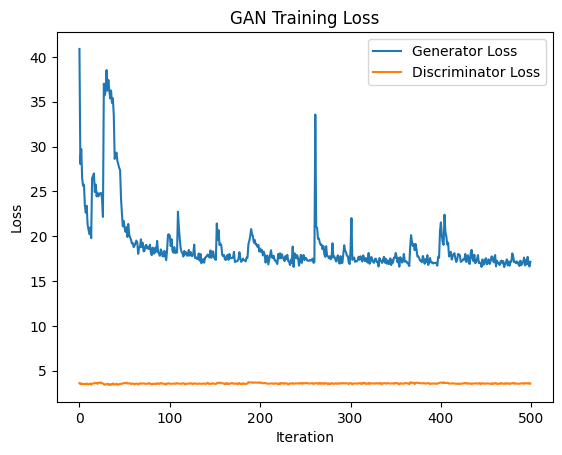

In [ ]:
# Plot the loss values
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.title('GAN Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()